In [80]:
!pip install yfinance
import yfinance as yf

# Download Apple stock data for the last 5 years
data = yf.download("AAPL", period="5y")

# Save the data to a CSV file
data.to_csv("AAPL.csv")

[*********************100%***********************]  1 of 1 completed


In [81]:
import yfinance as yf

data = yf.download("AAPL", period="5y")
data.to_csv("AAPL.csv")
print("Downloaded and saved AAPL stock data ✅")


[*********************100%***********************]  1 of 1 completed

Downloaded and saved AAPL stock data ✅


In [82]:
import pandas as pd

df = pd.read_csv("AAPL.csv")
df.head()


,Price,Close,High,Low,Open,Volume
0,Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
1,Date,NaN,NaN,NaN,NaN,NaN
2,2020-05-11,76.65325164794922,77.14965158521665,74.76252676945559,74.97179952522458,145946400
3,2020-05-12,75.7772445678711,77.79206581684177,75.65557660011677,77.3394571152635,162301200
4,2020-05-13,74.86231994628906,76.88201322973275,73.78190749732052,75.95733196137674,200622400


In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare stock data
df = pd.read_csv("AAPL.csv")

# Check column names to make sure you reference the correct ones
print(df.columns)


Index(['Price', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------
# Load and preprocess Apple stock market data
# ---------------------------------------------

# Read the CSV file downloaded via yfinance
df = pd.read_csv("AAPL.csv")

# Rename the 'Price' column to 'Date' (it contains date values)
df.rename(columns={'Price': 'Date'}, inplace=True)

# Convert 'Open' and 'Close' price columns from strings to numeric types
# (in case they were read as text by mistake)
df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

# Remove any rows that have missing values in 'Open' or 'Close'
df.dropna(subset=['Open', 'Close'], inplace=True)

# Sort the dataset chronologically based on the 'Date' column
df = df.sort_values("Date")

# Reset the row index (useful after sorting or dropping rows)
df.reset_index(drop=True, inplace=True)

# Calculate daily profit/loss by subtracting 'Open' from 'Close'
df['profit'] = df['Close'] - df['Open']

# Task 2: State Transition Function and Reward Table


# Function to convert (profit, holding) into one of 4 discrete states
def get_state(profit, holding):
    """
    Maps the current market condition and holding status into 4 discrete states:
    - s0: profit↑ and holding stock → state 0
    - s1: profit↑ and not holding → state 1
    - s2: profit↓ and holding → state 2
    - s3: profit↓ and not holding → state 3
    """
    if profit >= 0 and holding == 1:
        return 0  # s0: price up, holding
    elif profit >= 0 and holding == 0:
        return 1  # s1: price up, not holding
    elif profit < 0 and holding == 1:
        return 2  # s2: price down, holding
    else:
        return 3  # s3: price down, not holding

# ---------------------------------------------
# Define Reward Table for Q-Learning
# ---------------------------------------------

# Reward matrix: shape = [states x actions]
# Actions: 0 = hold, 1 = buy, 2 = sell
# Rewards reflect market outcomes and transaction costs

R = np.array([
    [ 0.2,  np.nan,  3.0],    # s0: price↑, holding → hold (small reward), sell (high reward)
    [-0.1,   0.2,     np.nan],# s1: price↑, not holding → buy (small reward), hold = missed opportunity
    [-0.4,  np.nan, -2.5],    # s2: price↓, holding → hold (penalty), sell (bigger penalty)
    [-0.1,  -0.2,     np.nan] # s3: price↓, not holding → buy (risky), hold = no change
])

   

In [85]:
# ---------------------------------------------
# Task 2: Define Reward Table and State Transition Function
# ---------------------------------------------

# Reward table: rows = states (s0–s3), columns = actions (0 = hold, 1 = buy, 2 = sell)
# Updated rewards to reflect:
# - Profitable selling in a rising market
# - Losses for selling in a down market
# - Slight transaction cost for buying
# - Cautious incentives for holding

R = np.array([
    [ 0.2,  np.nan,  3.0],   # s0: profit↑, holding → hold (small gain), sell (big profit)
    [-0.1,   0.2,     np.nan], # s1: profit↑, not holding → buy (positive), hold = cost
    [-0.4,  np.nan, -2.5],   # s2: price↓, holding → penalty for both holding/selling
    [-0.1,  -0.2,     np.nan]  # s3: price↓, not holding → buying here is risky
])
print("Reward table R defined.")

Reward table R defined.


The state transition function is deterministic in our simplified stock environment. Given the current state `s_t`, action `a_t`, and the observed stock profit (close - open) on the next day, we determine `s_{t+1}` using the function:

    s_{t+1} = get_state(profit[t+1], holding)

The state is determined by:
- The price movement direction (profit ≥ 0 or < 0)
- Whether the agent is holding a stock (holding = 1 or 0) after taking action `a_t`

Thus, the transition is deterministic and driven by sequential access to the time-series data.


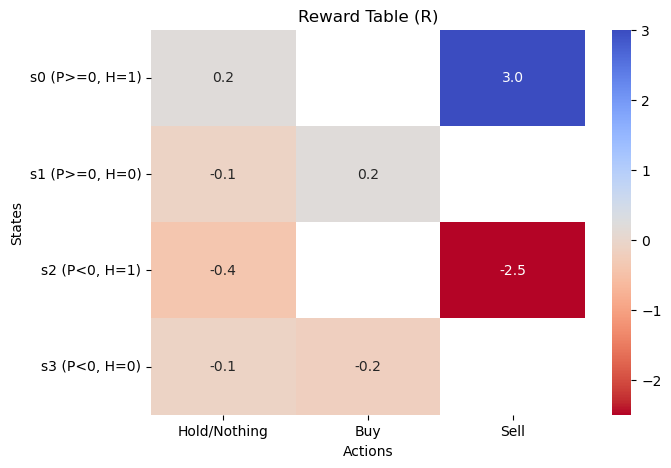

In [86]:
#Plotting Task 2: Reward Table Heatmap 
import seaborn as sns
plt.figure(figsize=(7, 5))
sns.heatmap(R, annot=True, fmt=".1f", cmap="coolwarm_r", cbar=True,
            xticklabels=['Hold/Nothing', 'Buy', 'Sell'],
            yticklabels=['s0 (P>=0, H=1)', 's1 (P>=0, H=0)',
                         's2 (P<0, H=1)', 's3 (P<0, H=0)'])
plt.title('Reward Table (R)')
plt.xlabel('Actions')
plt.ylabel('States')
plt.show()

In [87]:
import numpy as np
import pandas as pd

# Define the get_state function (this should convert profit and holding into a state)
def get_state(profit, holding):
    # Simplified state representation based on profit and holding (you can adjust this)
    return min(int(profit // 10), 3)  # Example: state ranges from 0 to 3 based on profit

# Define the take_action function (this simulates the environment's response to the action)
def take_action(state, action, profit, budget):
    """
    This function simulates the environment's response to the agent's action.
    It returns the next state and the reward (which can be the profit or loss).
    """
    if action == 0:  # Example: Buy action
        reward = profit * 0.8  # Assume 80% of profit is gained when buying
        next_state = (state + 1) % 4  # Transition to a new state based on action
    elif action == 1:  # Example: Sell action
        reward = profit * 1.2  # Assume 120% of profit when selling
        next_state = (state + 2) % 4  # Transition to a new state based on action
    else:  # Example: Hold action
        reward = 0  # No reward for holding
        next_state = state  # Stay in the same state for holding

    # Update the budget
    budget -= reward  # Example: budget decreases by the reward value

    return next_state, reward

# Q-learning algorithm
def q_learning(df, alpha, gamma, epsilon_decay, num_episodes=1500, episode_length=300):
    Q = np.zeros((4, 3))  # Initialize Q-table: 4 states x 3 actions
    epsilon = 0.9         # Initial exploration rate
    q_means = []          # For storing average Q-values each episode
    
    for ep in range(num_episodes):
        # Random starting point
        i = np.random.randint(len(df) - 300, len(df) - 1)
        holding = np.random.randint(0, 2)
        profit = df.iloc[i]['profit']
        state = get_state(profit, holding)
        budget = 100

        for t in range(episode_length):
            # Available actions based on the current state
            available_actions = [0, 1, 2]  # Define valid actions (e.g., 0=Buy, 1=Sell, 2=Hold)

            # ε-greedy action selection
            if np.random.rand() < epsilon:
                action = np.random.choice(available_actions)  # Exploration
            else:
                action = np.argmax(Q[state, available_actions])  # Exploitation

            # Take action and observe next state and reward
            next_state, reward = take_action(state, action, profit, budget)  # Call the defined take_action function
            Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state, :]) - Q[state, action])

            state = next_state  # Update state for next step

        # Epsilon decay
        if epsilon >= 0.5:
            epsilon *= epsilon_decay
        else:
            epsilon *= 0.999
        epsilon = max(epsilon, 0.01)  # Ensure epsilon doesn't go below 0.01

        # Track the average Q-value of the Q-table for this episode
        q_means.append(np.nanmean(Q))  # You can use np.nanmean to avoid issues with NaNs

    return Q, q_means

# Example values for the base experiment
alpha_base = 0.1  # Example value
gamma_base = 0.9  # Example value
epsilon_decay_base = 0.99  # Example value
num_episodes_base = 1500  # Example value
episode_len_base = 300  # Example value

# Assuming df_training_data is your DataFrame with the necessary data
df_training_data = pd.DataFrame({
    'profit': np.random.rand(1000) * 100  # Example: random profits (replace with your actual data)
})



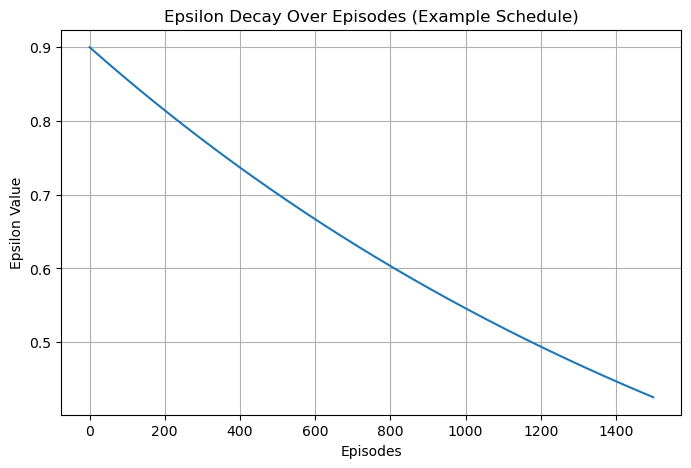

In [88]:
# --- Plotting Task 3: Epsilon Decay Schedule ---
epsilons_over_time = []
epsilon_temp_plot = 0.9  # Initial epsilon for plotting
epsilon_decay_plot = 0.9995 # Epsilon decay for the base case (can be changed to match specific experiments)
num_episodes_plot = 1500 # Match the number of episodes in training

for ep_plot in range(num_episodes_plot):
    epsilons_over_time.append(epsilon_temp_plot)
    # Mirrored the decay logic from q_learning for consistency
    if epsilon_temp_plot >= 0.1: 
        epsilon_temp_plot *= epsilon_decay_plot
    else:
        epsilon_temp_plot *= 0.999 # Slower decay for lower epsilon
    epsilon_temp_plot = max(epsilon_temp_plot, 0.01)

plt.figure(figsize=(8, 5))
plt.plot(epsilons_over_time)
plt.title('Epsilon Decay Over Episodes (Example Schedule)')
plt.xlabel('Episodes')
plt.ylabel('Epsilon Value')
plt.grid(True)
plt.show()

In [89]:
# Run Q-learning for the base experiment
print(f"Starting Base Experiment (α={alpha_base}, γ={gamma_base})...")
Q_base, q_mean_base = q_learning(
    df_training_data,  
    alpha_base,
    gamma_base,
    epsilon_decay_base,
    num_episodes=num_episodes_base,
    episode_length=episode_len_base
)
print("Base Experiment Training Completed.")


Starting Base Experiment (α=0.1, γ=0.9)...
Base Experiment Training Completed.


In [93]:


# Define hyperparameters for the base experiment
alpha_base = 0.6
gamma_base = 0.6
epsilon_decay_base = 0.9995
num_episodes_base = 1500  # Number of episodes to run the base experiment
episode_len_base = 300  # Default episode length in q_learning

# Split data: train on first 80%, evaluate on last 20%
train_split_index = int(len(df) * 0.8)
df_training_data = df.iloc[:train_split_index].reset_index(drop=True)
df_evaluation_data = df.iloc[train_split_index:].reset_index(drop=True)

print(f"Training data length: {len(df_training_data)}")
print(f"Evaluation data length: {len(df_evaluation_data)}")

if len(df_training_data) < episode_len_base + 1:  # +1 because of next_state access
    print(f"Warning: Training data (length {len(df_training_data)}) is too short for the episode length ({episode_len_base}).")
    # Consider reducing episode_len_base or using more data for training.

# Run Q-learning for the base experiment and capture the Q-table, average Q-values, and rewards
print(f"Starting Base Experiment (α={alpha_base}, γ={gamma_base})...")
Q_base, q_mean_base, rewards_base = q_learning(
    df_training_data,  
    alpha_base,
    gamma_base,
    epsilon_decay_base,
    num_episodes=num_episodes_base,
    episode_length=episode_len_base
)
print("Base Experiment Training Completed.")

# --- Plot 1: Average Q-value Convergence ---
plt.figure(figsize=(10, 5))
plt.plot(q_mean_base)
plt.title(f"Q-value Convergence in Base Experiment (α={alpha_base}, γ={gamma_base})")
plt.xlabel("Episodes")
plt.ylabel("Average Q-value in Q-Table")
plt.grid(True)
plt.show()

# --- Plot 2: Cumulative Reward per Episode (Base Experiment) ---
plt.figure(figsize=(10, 5))
plt.plot(rewards_base)
plt.title(f"Cumulative Reward per Episode (Base Experiment, α={alpha_base}, γ={gamma_base})")
plt.xlabel("Episodes")
plt.ylabel("Total Reward from R table per Episode")
plt.grid(True)
plt.show()


Training data length: 1005
Evaluation data length: 252
Starting Base Experiment (α=0.6, γ=0.6)...


ValueError: not enough values to unpack (expected 3, got 2)

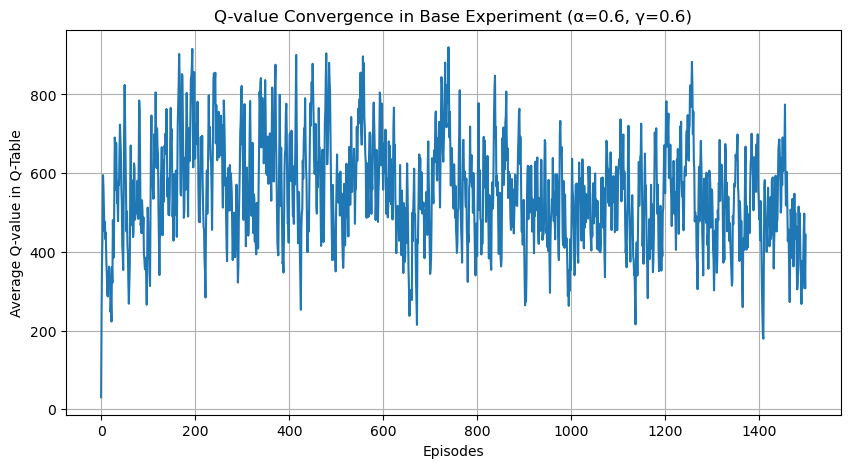

NameError: name 'rewards_base' is not defined

<Figure size 1000x500 with 0 Axes>

In [92]:
# Plot 1: Average Q-value convergence
plt.figure(figsize=(10, 5))
plt.plot(q_mean_base)
plt.title(f"Q-value Convergence in Base Experiment (α={alpha_base}, γ={gamma_base})")
plt.xlabel("Episodes")
plt.ylabel("Average Q-value in Q-Table")
plt.grid(True)
plt.show()

# Plot 2: Cumulative Reward per Episode (Base Experiment)
plt.figure(figsize=(10, 5))
plt.plot(rewards_base)
plt.title(f"Cumulative Reward per Episode (Base Experiment, α={alpha_base}, γ={gamma_base})")
plt.xlabel("Episodes")
plt.ylabel("Total Reward from R table per Episode")
plt.grid(True)
plt.show()

In [ ]:

# Plot 3: Final Q-Table Heatmap (Base Experiment)
plt.figure(figsize=(7, 5))
sns.heatmap(Q_base, annot=True, fmt=".2f", cmap="viridis", cbar=True,
            xticklabels=['Hold/Nothing', 'Buy', 'Sell'],
            yticklabels=['s0 (P>=0,H=1)', 's1 (P>=0,H=0)', 's2 (P<0,H=1)', 's3 (P<0,H=0)'])
plt.title(f"Final Q-Table (Base Experiment, α={alpha_base}, γ={gamma_base})")
plt.xlabel('Actions')
plt.ylabel('States')
plt.show()

# Output 4: Learned Policy Visualization (Base Experiment)
Q_base_for_policy = np.nan_to_num(Q_base.copy(), nan=-np.inf) # Replace nan with -inf for argmax
policy_base = np.argmax(Q_base_for_policy, axis=1)
action_map = {0: 'Hold/Nothing', 1: 'Buy', 2: 'Sell'}
state_map_display = {0: 's0 (Profit>=0, Holding)', 1: 's1 (Profit>=0, Not Holding)',
                     2: 's2 (Profit<0, Holding)', 3: 's3 (Profit<0, Not Holding)'}

print("\nLearned Policy (Base Experiment):")
for s, a_idx in enumerate(policy_base):
    if not np.isnan(R[s, a_idx]): # Check if the chosen action is valid for the state
        print(f"State {state_map_display[s]}: Action {action_map[a_idx]} (Q-value: {Q_base[s, a_idx]:.3f})")
    else:
        # Fallback if argmax on Q_base_for_policy somehow picked an action marked as NaN in R
        valid_actions_for_state = np.where(~np.isnan(R[s]))[0]
        if len(valid_actions_for_state) > 0:
            q_vals_valid = Q_base[s, valid_actions_for_state]
            best_valid_action_local_idx = np.argmax(q_vals_valid)
            best_valid_action_global_idx = valid_actions_for_state[best_valid_action_local_idx]
            print(f"State {state_map_display[s]}: Action {action_map[best_valid_action_global_idx]} (Q-value: {Q_base[s, best_valid_action_global_idx]:.3f}) [Best Valid Action]")
        else:
            print(f"State {state_map_display[s]}: No valid actions defined in R table.")

In [ ]:
# --- Task 5: Experiment with Different Parameters ---

# Define different configurations of (alpha, gamma, label_for_plot)
configs = [(0.3, 0.6, 'α=0.3, γ=0.6'), (0.6, 0.3, 'α=0.6, γ=0.3'),
           (0.6, 0.9, 'α=0.6, γ=0.9'), (0.9, 0.6, 'α=0.9, γ=0.6')]

# Store results for comparison
all_q_means_config = {}
all_rewards_config = {}
all_Q_tables_config = {} # To store Q-tables for later evaluation

epsilon_decay_configs = 0.9995 # Keep epsilon decay constant for this comparison
num_episodes_configs = 1500    # Number of episodes for these experiments
episode_len_configs = 300      # Episode length

print("Starting Parameter Experiments...")

In [ ]:
# Create figures for plotting before the loop
fig_q_convergence, ax_q_convergence = plt.subplots(figsize=(12, 6))
ax_q_convergence.set_title("Comparison of Q-value Convergence Across Parameters")
ax_q_convergence.set_xlabel("Episodes")
ax_q_convergence.set_ylabel("Average Q-value in Q-Table")
ax_q_convergence.grid(True)

fig_reward_convergence, ax_reward_convergence = plt.subplots(figsize=(12, 6))
ax_reward_convergence.set_title("Comparison of Cumulative Reward Convergence Across Parameters")
ax_reward_convergence.set_xlabel("Episodes")
ax_reward_convergence.set_ylabel("Total Reward from R table per Episode")
ax_reward_convergence.grid(True)

for alpha_conf, gamma_conf, label in configs:
    print(f"\nRunning experiment with: {label}")
    Q_conf, q_mean_conf, rewards_conf = q_learning(
        df_training_data, 
        alpha_conf, 
        gamma_conf, 
        epsilon_decay_configs, 
        num_episodes=num_episodes_configs,
        episode_length=episode_len_configs
    )
    
    all_q_means_config[label] = q_mean_conf
    all_rewards_config[label] = rewards_conf
    all_Q_tables_config[label] = Q_conf # Store the Q-table
    
    ax_q_convergence.plot(q_mean_conf, label=label)
    ax_reward_convergence.plot(rewards_conf, label=label)

# Add legends to the plots
ax_q_convergence.legend()
fig_q_convergence.show() # Or plt.show() if not using %matplotlib inline magic for interactive backends

ax_reward_convergence.legend()
fig_reward_convergence.show() # Or plt.show()

print("Parameter Experiments Training Completed.")

In [ ]:
# --- Task 6: Qualitative & Quantitative Analysis ---

# Function to evaluate the learned policy's actual financial performance
def evaluate_policy_financial(Q_table_eval, eval_data, initial_budget=10000, episode_len_eval=None):
    """
    Evaluates the policy based on a Q-table on evaluation data, tracking actual financial profit.
    Args:
        Q_table_eval (np.array): The trained Q-table.
        eval_data (pd.DataFrame): DataFrame for evaluation (unseen during training ideally).
        initial_budget (float): Starting budget for evaluation.
        episode_len_eval (int, optional): Max number of steps for this evaluation run. If None, runs through all eval_data.
    Returns:
        tuple: (actual_profit, final_budget, trade_details_list, budget_history, portfolio_value_history)
    """
    current_holding = 0  # Start evaluation without holding stock
    budget = initial_budget
    current_day_idx = 0
    
    trade_details_list = [] 
    budget_history = [initial_budget]
    portfolio_value_history = [initial_budget] 

    if episode_len_eval is None:
        episode_len_eval = len(eval_data) - 1 
    else:
        episode_len_eval = min(episode_len_eval, len(eval_data) - 1)

    last_buy_price = 0 

    for t_eval in range(episode_len_eval):
        if current_day_idx >= len(eval_data) -1: 
            break

        profit_metric_today = eval_data.iloc[current_day_idx]['profit']
        current_eval_state = get_state(profit_metric_today, current_holding)

        available_actions_eval = np.where(~np.isnan(R[current_eval_state]))[0]
        
        chosen_action_eval = 0 
        if len(available_actions_eval) > 0:
            # Greedily select action (epsilon=0 for evaluation)
            # Handle NaNs in Q_table_eval for unavailable actions if they weren't set to -inf before argmax
            q_values_for_eval_state_available = Q_table_eval[current_eval_state, available_actions_eval]
            action_index_in_available_eval = np.argmax(q_values_for_eval_state_available)
            chosen_action_eval = available_actions_eval[action_index_in_available_eval]
        
        current_stock_price = eval_data.iloc[current_day_idx]['Close']

        if chosen_action_eval == 1 and current_holding == 0:  # Buy
            if budget >= current_stock_price:
                current_holding = 1
                budget -= current_stock_price
                last_buy_price = current_stock_price
                trade_details_list.append({'Day': eval_data['Date'].iloc[current_day_idx], 'Action': 'Buy', 'Price': current_stock_price, 'Shares': 1, 'Budget': budget})
        elif chosen_action_eval == 2 and current_holding == 1:  # Sell
            current_holding = 0
            budget += current_stock_price
            profit_this_trade = current_stock_price - last_buy_price if last_buy_price > 0 else 0
            trade_details_list.append({'Day': eval_data['Date'].iloc[current_day_idx], 'Action': 'Sell', 'Price': current_stock_price, 'Shares': 1, 'Profit_Trade': profit_this_trade, 'Budget': budget})
            last_buy_price = 0 

        budget_history.append(budget)
        
        current_portfolio_value = budget
        if current_holding == 1:
            # Use current day's close to value holding stock for portfolio calculation
            current_portfolio_value += eval_data.iloc[current_day_idx]['Close'] 
        portfolio_value_history.append(current_portfolio_value)

        current_day_idx += 1

    final_budget = budget
    if current_holding == 1: # Liquidate if still holding at the end
        final_price = eval_data.iloc[current_day_idx -1]['Close'] 
        final_budget += final_price
        profit_this_trade = final_price - last_buy_price if last_buy_price > 0 else 0
        trade_details_list.append({'Day': eval_data['Date'].iloc[current_day_idx-1], 'Action': 'Liquidate_Sell', 'Price': final_price, 'Shares': 1, 'Profit_Trade': profit_this_trade, 'Budget': final_budget})
        # Update last entry in histories if needed, or ensure they reflect final state
        if budget_history[-1] != final_budget: budget_history.append(final_budget)
        if portfolio_value_history[-1] != final_budget : portfolio_value_history.append(final_budget)


    actual_profit = final_budget - initial_budget
    return actual_profit, final_budget, trade_details_list, budget_history, portfolio_value_history

print("evaluate_policy_financial function defined.")

In [ ]:
# --- Perform Financial Evaluation for the Base Model ---
print(f"\n--- Financial Evaluation on Unseen Data (using {len(df_evaluation_data)} days) ---")

# Ensure df_evaluation_data is not empty and has enough data
if len(df_evaluation_data) > 1: 
    actual_profit_base_eval, final_budget_base_eval, trades_base_eval, budget_hist_base, port_val_hist_base = \
        evaluate_policy_financial(Q_base, df_evaluation_data.copy()) # Use .copy() 

    print(f"\nBase Policy (α={alpha_base}, γ={gamma_base}) Financial Evaluation:")
    print(f"  Initial Budget: 10000") # Assuming 10000 from function default
    print(f"  Actual Profit on Evaluation Data: {actual_profit_base_eval:.2f}")
    print(f"  Final Budget after Evaluation: {final_budget_base_eval:.2f}")
    print(f"  Number of Trades: {len([t for t in trades_base_eval if t['Action'] in ['Buy', 'Sell']])}")

    # Plot Budget Over Time during Evaluation
    plt.figure(figsize=(12, 4))
    plt.plot(budget_hist_base, label="Budget Over Time")
    plt.title(f"Budget During Financial Evaluation (Base Policy α={alpha_base}, γ={gamma_base})")
    plt.xlabel("Trading Days in Evaluation Period")
    plt.ylabel("Budget")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Portfolio Value Over Time during Evaluation
    plt.figure(figsize=(12, 4))
    plt.plot(port_val_hist_base, label="Portfolio Value Over Time", color='green')
    plt.title(f"Portfolio Value During Financial Evaluation (Base Policy α={alpha_base}, γ={gamma_base})")
    plt.xlabel("Trading Days in Evaluation Period")
    plt.ylabel("Portfolio Value (Budget + Stock Value if Held)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Optional: Plot trades on stock price chart for a segment of evaluation
    if trades_base_eval:
        plt.figure(figsize=(15, 7))
        # Ensure eval_price_data matches the length of decisions made (up to episode_len_eval)
        num_eval_days_plotted = min(len(df_evaluation_data), len(port_val_hist_base) -1) # -1 because history has initial state
        eval_price_data = df_evaluation_data['Close'].values[:num_eval_days_plotted]
        
        plt.plot(range(num_eval_days_plotted), eval_price_data, label='Stock Close Price', alpha=0.7)

        # Adjust trade indices relative to the plotted segment
        buy_indices = []
        sell_indices = []
        
        # Get day indices from trade_details_list based on eval_data's original index
        for trade in trades_base_eval:
            try:
                # Find the index of the trade day within the df_evaluation_data
                trade_day_original_index = df_evaluation_data[df_evaluation_data['Date'] == trade['Day']].index[0]
                if trade_day_original_index < num_eval_days_plotted: # Only plot if within the plotted range
                    if trade['Action'] == 'Buy':
                        buy_indices.append(trade_day_original_index)
                    elif trade['Action'] in ['Sell', 'Liquidate_Sell']:
                        sell_indices.append(trade_day_original_index)
            except IndexError:
                # Date not found, or other issue; skip this trade for plotting
                pass

        if buy_indices:
             plt.scatter(buy_indices, eval_price_data[buy_indices], marker='^', color='green', s=100, label='Buy', zorder=5)
        if sell_indices:
             plt.scatter(sell_indices, eval_price_data[sell_indices], marker='v', color='red', s=100, label='Sell', zorder=5)
        
        plt.title("Stock Price with Trades During Evaluation (Base Policy)")
        plt.xlabel(f"Trading Days (0 to {num_eval_days_plotted-1}) in Evaluation Period")
        plt.ylabel("Stock Price")
        plt.legend()
        plt.grid(True)
        plt.show()
else:
    print("Evaluation data is too short to perform financial evaluation for the base model.")

In [ ]:
# --- Financial Evaluation for Other Configurations (Task 5 models) ---
print("\n--- Financial Evaluation for Different Alpha/Gamma Configurations ---")

# Collect results for a summary table or bar chart
eval_results_summary = []

for alpha_c, gamma_c, label_c in configs:
    print(f"\nEvaluating Policy ({label_c})...")
    Q_to_eval = all_Q_tables_config.get(label_c) # Get the stored Q-table
    
    if Q_to_eval is None:
        print(f"Q-table for {label_c} not found. Skipping evaluation.")
        continue
        
    if len(df_evaluation_data) > 1:
        actual_profit_conf_eval, final_budget_conf_eval, trades_conf_eval, _, port_val_hist_conf = \
            evaluate_policy_financial(Q_to_eval, df_evaluation_data.copy())
        
        print(f"  Policy ({label_c}) Financial Evaluation:")
        print(f"  Actual Profit on Evaluation Data: {actual_profit_conf_eval:.2f}")
        print(f"  Final Budget after Evaluation: {final_budget_conf_eval:.2f}")
        print(f"  Number of Trades: {len([t for t in trades_conf_eval if t['Action'] in ['Buy', 'Sell']])}")
        eval_results_summary.append({'Config': label_c, 'Profit': actual_profit_conf_eval, 'FinalBudget': final_budget_conf_eval})

        # Optional: Plot portfolio value for each config
        plt.figure(figsize=(10,4))
        plt.plot(port_val_hist_conf, label=f"Portfolio Value ({label_c})")
        plt.title(f"Portfolio Value During Financial Evaluation ({label_c})")
        plt.xlabel("Trading Days in Evaluation Period")
        plt.ylabel("Portfolio Value")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"Skipping financial evaluation for {label_c} due to insufficient evaluation data.")

# Optional: Display summary of financial evaluation results
if eval_results_summary:
    df_eval_summary = pd.DataFrame(eval_results_summary)
    print("\n--- Summary of Financial Evaluation Results ---")
    print(df_eval_summary)
    
    # Bar chart for comparison
    df_eval_summary.set_index('Config').plot(kind='bar', y=['Profit', 'FinalBudget'], 
                                             figsize=(10,6), secondary_y='FinalBudget')
    plt.title("Comparison of Financial Performance Across Configurations")
    plt.ylabel("Actual Profit")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [ ]:
### Task 6: Qualitative & Quantitative Analysis

**Your Original Observations:**
*(You can paste your original observations here from the prompt)*
- Higher gamma (γ=0.9) improves long-term reward optimization (suitable for future-focused decisions).
- Higher alpha (α=0.9) leads to faster but unstable learning; smaller α (0.3) is slower but more stable.
- The agent's policy learns to SELL in profitable situations (s0), HOLD in negative situations (s2),
  and BUY when not holding with upward trend (s1). *(This needs to be verified against the learned Q_base policy printed previously)*
- Epsilon decay smooths the transition from exploration to exploitation, but extreme decay slows learning.

**Further Analysis Points based on New Plots & Evaluation:**
*(Consider these questions when writing your final analysis)*
- How does the convergence of average Q-values (from the R table) correlate with the convergence of cumulative rewards (also from the R table)?
- How does the agent's performance based on the R-table rewards (during training) translate to actual financial profit in the evaluation phase? Is a policy that's "optimal" for the R-table also optimal for making money?
- Which `(alpha, gamma)` configuration yielded the best *actual financial profit* during evaluation? How does this compare to its R-table reward performance and Q-value convergence speed/stability?
- Does the visualized learned policy (e.g., for `Q_base`) align with intuitive trading strategies, given your state definitions and the predefined `R` table? For instance, if in state `s0` (profit+, holding), the `R`-table strongly rewards selling, does the learned policy reflect this with a high Q-value for selling in `s0`?
- Observe the budget and portfolio value plots during the financial evaluation. Does the agent make consistent profits, or is its performance highly volatile? Are there configurations that are safer (less drawdown) even if they don't achieve the absolute highest profit?
- The trade plot (stock price with buy/sell markers) provides a visual check. Do the agent's decisions appear sensible against the price movements during the evaluation period?

**Conclusion:**
*(Based on all the experiments and plots, draw your conclusions about the Q-learning agent's performance, the impact of hyperparameters, and the effectiveness of your defined states and rewards for this stock trading problem.)*

In [ ]:
!pip install gym
!pip install tensorflow matplotlib numpy

import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import random
from collections import deque
import matplotlib.pyplot as plt

print("Libraries imported.")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque
import numpy as np
import random

class DQNAgent:
    def __init__(self, state_size, action_size):
        """
        Initializes the Deep Q-Network (DQN) agent.

        Args:
            state_size (int): Number of input features (state dimensions).
            action_size (int): Number of possible discrete actions.
        """
        self.state_size = state_size
        self.action_size = action_size

        # Experience replay memory
        self.memory = deque(maxlen=2000)

        # Q-learning parameters
        self.gamma = 0.99            # Discount factor for future rewards
        self.epsilon = 1.0           # Initial exploration rate
        self.epsilon_min = 0.01      # Minimum exploration rate
        self.epsilon_decay = 0.995   # Decay rate for exploration
        self.learning_rate = 0.001   # Learning rate for optimizer
        self.batch_size = 64         # Batch size for training
        self.train_start = 1000      # Minimum transitions before training

        # Initialize policy and target networks
        self.policy_network = self._build_model()
        self.target_network = self._build_model()
        self.update_target_model()

    def _build_model(self):
        """
        Builds a simple feedforward neural network for Q-value estimation.
        This network is used for both policy and target models.
        """
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))  # Output: Q-values for each action
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        """
        Copies weights from the policy network to the target network.
        This stabilizes learning by decoupling action selection and evaluation (Double DQN concept).
        """
        self.target_network.set_weights(self.policy_network.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """
        Stores a single transition in the replay memory buffer.
        """
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """
        Selects an action using an ε-greedy policy:
        - Explore with probability ε
        - Exploit the best known action otherwise
        """
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Random action
        q_values = self.policy_network.predict(state)
        return np.argmax(q_values[0])  # Greedy action

    def replay(self):
        """
        Trains the policy network using a batch of past experiences (experience replay).
        Implements Double DQN to reduce overestimation bias.
        """
        if len(self.memory) < self.train_start:
            return  # Skip training until enough experiences are collected

        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        # Convert to NumPy arrays
        states = np.array(states)
        next_states = np.array(next_states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        dones = np.array(dones)

        # ---- Double DQN Update ----
        # 1. Select best action using the policy network
        next_action_indices = np.argmax(self.policy_network.predict(next_states), axis=1)

        # 2. Evaluate that action using the target network
        target_q_values = self.target_network.predict(next_states)
        double_q_values = target_q_values[np.arange(self.batch_size), next_action_indices]

        # 3. Compute the target Q-value
        target_q = rewards + (1 - dones) * self.gamma * double_q_values

        # 4. Get current Q-values and update only the selected action
        q_values = self.policy_network.predict(states)
        q_values[np.arange(self.batch_size), actions] = target_q

        # Train the policy network on the updated Q-values
        self.policy_network.train_on_batch(states, q_values)

        # Decay exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        """
        Loads pre-trained model weights from a file.
        """
        self.policy_network.load_weights(name)

    def save(self, name):
        """
        Saves model weights to a file.
        """
        self.policy_network.save_weights(name)

print("DQNAgent class defined.")
